In [2]:
!pip install pymagnitude pytorch_pretrained_bert -q

     |████████████████████████████████| 5.4MB 85kB/s 
     |████████████████████████████████| 133kB 42.1MB/s 


In [0]:
import torch
import torch.nn as nn
from pymagnitude import Magnitude
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

RED, BLUE = '#FF4136', '#0074D9'

# Embeddings

An embedding maps discrete, categorical values to a continous space. Major advances in NLP applications have come from these continuous representations of words.

If we have some sentence,

In [4]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

We first turn this sentence into numbers by assigning each unique word an integer.

In [5]:
word2idx = {word: idx for idx, word in enumerate(sorted(set(words)))}
word2idx

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

Then, we turn each word in our sentence into its assigned index.

In [6]:
idxs = torch.LongTensor([word2idx[word] for word in sentence.split()])
idxs

tensor([7, 6, 0, 2, 3, 5, 7, 4, 1])

Next, we want to create an **embedding layer**. The embedding layer is a 2-D matrix of shape `(n_vocab x embedding_dimension)`. If we apply our input list of indices to the embedding layer, each value in the input list of indices maps to that specific row of the embedding layer matrix. The output shape after applying the input list of indices to the embedding layer is another 2-D matrix of shape `(n_words x embedding_dimension)`.

In [7]:
embedding_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=3)
embeddings = embedding_layer(idxs)
embeddings, embeddings.shape

(tensor([[-0.6273,  1.3656, -0.8692],
         [-0.9951, -0.3210, -0.4607],
         [-1.0486,  0.2298, -0.5650],
         [-0.0486, -0.3413, -0.3263],
         [-1.0021,  1.4270,  0.0433],
         [-0.6791, -0.4597,  1.8933],
         [-0.6273,  1.3656, -0.8692],
         [-0.1996,  2.0420, -1.2170],
         [ 0.0526, -0.3234,  0.9123]], grad_fn=<EmbeddingBackward>),
 torch.Size([9, 3]))

The PyTorch builtin embedding layer comes with randomly initialized weights that are updated with gradient descent as your model learns to map input indices to some kind of output. However, often it is better to use pretrained embeddings that do not update but instead are frozen.

## GloVe Embeddings

GloVe embeddings are one of the most popular pretrained word embeddings in use. You can download them [here](https://nlp.stanford.edu/projects/glove/). For the best performance for most applications, I recommend using their Common Crawl embeddings with 840B tokens; however, they take the longest to download, so instead let's download the Wikipedia embeddings with 6B tokens

In [0]:
# Download GloVe vectors (uncomment the below)

# !wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip && mkdir glove && mv glove*.txt glove

# GLOVE_FILENAME = 'glove/glove.6B.50d.txt'
# glove_index = {}
# n_lines = sum(1 for line in open(GLOVE_FILENAME))
# with open(GLOVE_FILENAME) as fp:
#     for line in tqdm(fp, total=n_lines):
#         split = line.split()
#         word = split[0]
#         vector = np.array(split[1:]).astype(float)
#         glove_index[word] = vector
        
# glove_embeddings = np.array([glove_index[word] for word in words])

# # Because the length of the input sequence is 9 words and the embedding
# # dimension is 50, the output shape is `(9 x 50)`.
# glove_embeddings.shape

### Magnitude Library for Fast Vector Loading

Loading the entire GloVe file can take up a lot of memory. We can use the `magnitude` library for more efficient embedding vector loading. You can download the magnitude version of GloVe embeddings [here](https://github.com/plasticityai/magnitude#pre-converted-magnitude-formats-of-popular-embeddings-models).

In [10]:
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude glove/

--2019-05-03 10:21:05--  http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.217.1.67
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.217.1.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102670336 (98M) [binary/octet-stream]
Saving to: ‘glove.6B.50d.magnitude’

glove.6B.50d.magnit 100%[===================>]  97.91M  49.2MB/s    in 2.0s    

2019-05-03 10:21:08 (49.2 MB/s) - ‘glove.6B.50d.magnitude’ saved [102670336/102670336]

--2019-05-03 10:21:08--  http://glove/
Resolving glove (glove)... failed: Name or service not known.
wget: unable to resolve host address ‘glove’
FINISHED --2019-05-03 10:21:08--
Total wall clock time: 2.2s
Downloaded: 1 files, 98M in 2.0s (49.2 MB/s)


In [0]:
# Load Magnitude GloVe vectors
glove_vectors = Magnitude('glove/glove.6B.50d.magnitude')

In [0]:
glove_embeddings = glove_vectors.query(words)

## Similarity operations on embeddings

In [0]:
def cosine_similarity(word1, word2):
    vector1, vector2 = glove_vectors.query(word1), glove_vectors.query(word2)
    return 1 - spatial.distance.cosine(vector1, vector2)

In [14]:
word_pairs = [
    ('dog', 'cat'),
    ('tree', 'cat'),
    ('tree', 'leaf'),
    ('king', 'queen'),
]

for word1, word2 in word_pairs:
    print(f'Similarity between "{word1}" and "{word2}":\t{cosine_similarity(word1, word2):.2f}')

Similarity between "dog" and "cat":	0.92
Similarity between "tree" and "cat":	0.57
Similarity between "tree" and "leaf":	0.74
Similarity between "king" and "queen":	0.78


## Visualizing Embeddings

We can demonstrate that embeddings carry semantic information by plotting them. However, because our embeddings are more than three dimensions, they are impossible to visualize. Therefore, we can use an algorithm called t-SNE to project the word embeddings to a lower dimension in order to plot them in 2-D.

In [0]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]

HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [16]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS))
tsne_words_embedded.shape

(35, 2)

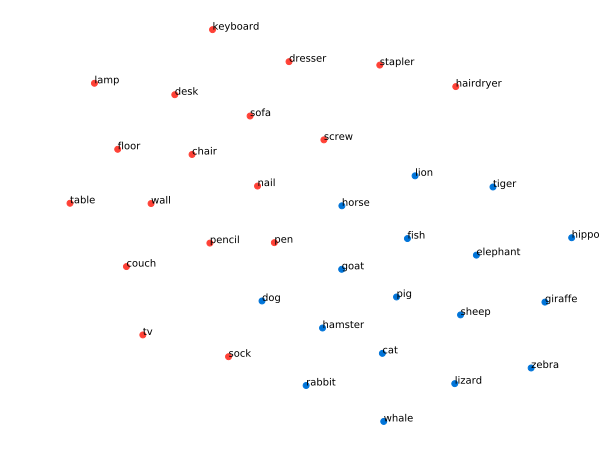

In [17]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(10, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
    if label in ANIMALS:
        color = BLUE
    elif label in HOUSEHOLD_OBJECTS:
        color = RED
        
    ax.scatter(x[i], y[i], c=color)
    ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

## Context embeddings

GloVe and Fasttext are two examples of global embeddings, where the embeddings don't change even though the "sense" of the word might change given the context. This can be a problem for cases such as:

- A **mouse** stole some cheese.
- I bought a new **mouse** the other day for my computer.

The word mouse can mean both an animal and a computer accessory depending on the context, yet for GloVe they would receive the same exact distributed representation. We can combat this by taking into account the surroudning words to create a context-sensitive embedding. Context embeddings such as Bert are really popular right now.



In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def to_bert_embeddings(text, return_tokens=False):
    if isinstance(text, list):
        # Already tokenized
        tokens = tokenizer.tokenize(' '.join(text))
    else:
        # Need to tokenize
        tokens = tokenizer.tokenize(text)
        
    tokens_with_tags = ['[CLS]'] + tokens + ['[SEP]']
    indices = tokenizer.convert_tokens_to_ids(tokens_with_tags)

    out = model(torch.LongTensor(indices).unsqueeze(0))
    
    # Concatenate the last four layers and use that as the embedding
    # source: https://jalammar.github.io/illustrated-bert/
    embeddings_matrix = torch.stack(out[0]).squeeze(1)[-4:]  # use last 4 layers
    embeddings = []
    for j in range(embeddings_matrix.shape[1]):
        embeddings.append(embeddings_matrix[:, j, :].flatten().detach().numpy())
        
    # Ignore [CLS] and [SEP]
    embeddings = embeddings[1:-1]
        
    if return_tokens:
        assert len(embeddings) == len(tokens)
        return embeddings, tokens
    
    return embeddings

100%|██████████| 407873900/407873900 [00:13<00:00, 29724168.81B/s]


In [0]:
words_sentences = [
    ('mouse', 'I saw a mouse run off with some cheese.'),
    ('mouse', 'I bought a new computer mouse yesterday.'),
    ('cat', 'My cat jumped on the bed.'),
    ('keyboard', 'My computer keyboard broke when I spilled juice on it.'),
    ('dessert', 'I had a banana fudge sunday for dessert.'),
    ('dinner', 'What did you eat for dinner?'),
    ('lunch', 'Yesterday I had a bacon lettuce tomato sandwich for lunch. It was tasty!'),
    ('computer', 'My computer broke after the motherdrive was overloaded.'),
    ('program', 'I like to program in Java and Python.'),
    ('pasta', 'I like to put tomatoes and cheese in my pasta.'),
]
words = [words_sentence[0] for words_sentence in words_sentences]
sentences = [words_sentence[1] for words_sentence in words_sentences]

In [0]:
embeddings_lst, tokens_lst = zip(*[to_bert_embeddings(sentence, return_tokens=True) for sentence in sentences])
words, tokens_lst, embeddings_lst = zip(*[(word, tokens, embeddings) for word, tokens, embeddings in zip(words, tokens_lst, embeddings_lst) if word in tokens])

# Convert tuples to lists
words, tokens_lst, tokens_lst = map(list, [words, tokens_lst, tokens_lst])

In [0]:
target_indices = [tokens.index(word) for word, tokens in zip(words, tokens_lst)]

In [0]:
target_embeddings = [embeddings[idx] for idx, embeddings in zip(target_indices, embeddings_lst)]

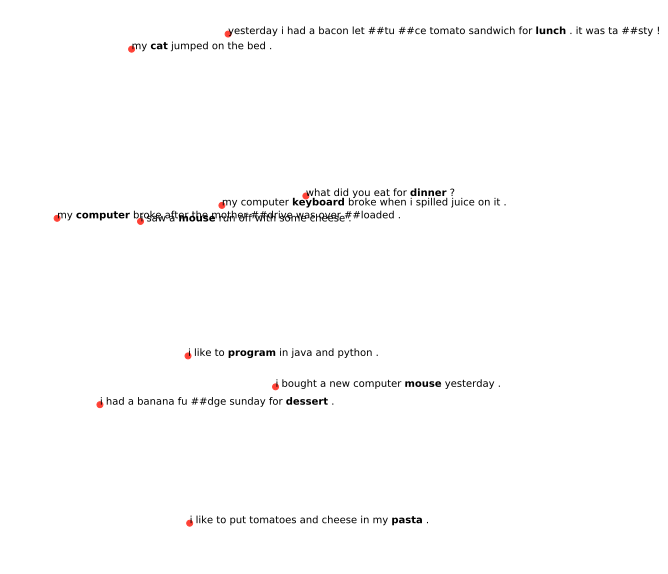

In [23]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(target_embeddings)
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(5, 10))

for word, tokens, x_i, y_i in zip(words, tokens_lst, x, y):
    ax.scatter(x_i, y_i, c=RED)
    ax.annotate(' '.join([f'$\\bf{x}$' if x == word else x for x in tokens]), (x_i, y_i))

ax.axis('off')
plt.show()

## Try-it-yourself

- Use the Magnitude library to load other pretrained embeddings such as Fasttext
- Try comparing the GloVe embeddings with the Fasttext embeddings by making t-SNE plots of both, or checking the similarity scores between the same set of words
- Make t-SNE plots using your own words and categories